In [1]:
# Goal: Create word vectors from GoT dataset
from __future__ import division, absolute_import, print_function
# For word encoding
import codecs
# regex
import glob
# Concurrency
import multiprocessing
# Dealing with os
import os
# pretty print
import pprint
# Regular expressions
import re
# Natural Language Toolkit
import nltk
# word2vesc
import gensim.models.word2vec as w2v
# Dimebnsionality reduction
import sklearn.manifold
# math
import numpy
import matplotlib.pyplot as plt
import pandas as pd
# Visualise
import seaborn as sns
%matplotlib inline

c:\users\shreyansh singh\appdata\local\programs\python\python35\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# Step 1: Process our data
# Clean data
nltk.download('punkt') # Tokenizer
nltk.download('stopwords') # Remove stop words

[nltk_data] Downloading package punkt to C:\Users\Shreyansh
[nltk_data]     Singh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Shreyansh
[nltk_data]     Singh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Prepare Corpus

## Get books

In [3]:
# get the book names
book_filenames = sorted(glob.glob('data/*.txt'))
book_filenames

['data\\got1.txt',
 'data\\got2.txt',
 'data\\got3.txt',
 'data\\got4.txt',
 'data\\got5.txt']

## Combine books to one string

In [4]:
corpus_raw = u""
for book_filename in book_filenames:
    print("Reading '{0}'...".format(book_filename))
    with codecs.open(book_filename, "r", "utf-8") as book_file:
        corpus_raw += book_file.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw)))
    print()

Reading 'data\got1.txt'...
Corpus is now 1787939 characters long

Reading 'data\got2.txt'...
Corpus is now 2801274 characters long

Reading 'data\got3.txt'...
Corpus is now 3650410 characters long

Reading 'data\got4.txt'...
Corpus is now 4035208 characters long

Reading 'data\got5.txt'...
Corpus is now 4772207 characters long



## Split corpus into sentences

In [5]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [6]:
raw_sentences = tokenizer.tokenize(corpus_raw)

In [7]:
def sentence_to_word_list(raw):
    clean = re.sub('[^a-zA-Z]', ' ', raw)
    words = clean.split()
    return words

In [8]:
sentences = []
for raw_sentence in raw_sentences:
    if(len(raw_sentence) > 0):
        sentences.append(sentence_to_word_list(raw_sentence))

In [9]:
print(raw_sentences[5])
print(sentence_to_word_list(raw_sentences[5]))

Heraldic crest by Virginia Norey.
['Heraldic', 'crest', 'by', 'Virginia', 'Norey']


In [10]:
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))  # {0:,} is for pretty formatting with commas, {0} works too.

The book corpus contains 886,924 tokens


# Train Word2Vec

In [11]:
# If we have vectors - 
# 3 main tasks that vectors help with
# DISTANCE, SIMILARTY, RANKING

# Dimensionality of word vectors
# More dimensions => More computing but more generalised
num_features = 300

# Min word count threshold
min_word_count = 3

# Number of threads to run in parallel
num_workers = multiprocessing.cpu_count()

# Context window length
context_size = 7

# Downsample settings for frequent words
downsampling = 1e-3

# Seed for RNG, to make results reproducible
seed = 1

In [12]:
thrones2vec = w2v.Word2Vec(
            sg=1,
            seed=seed,
            workers=num_workers,
            size=num_features,
            min_count=min_word_count,
            window=context_size,
            sample=downsampling
            )

In [13]:
thrones2vec.build_vocab(sentences)

In [14]:
print("Word2Vec vocab length:", len(thrones2vec.wv.vocab))

Word2Vec vocab length: 12047


## Training

In [15]:
thrones2vec.train(sentences, total_examples=thrones2vec.corpus_count, epochs=thrones2vec.iter)

3391600

## Save to file

In [16]:
if not os.path.exists("trained"):
    os.makedirs("trained")

In [17]:
thrones2vec.save(os.path.join("trained", "thrones2vec.w2v"))

## Explore the trained model

In [18]:
thrones2vec = w2v.Word2Vec.load(os.path.join("trained", "thrones2vec.w2v"))

### Compress the word vectors into 2D space and plot them

In [19]:
# Reduce dimensions
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [20]:
all_word_vectors_matrix = thrones2vec.wv.syn0

### Train TSNE

In [21]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

### Plot the big picture

In [22]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[thrones2vec.wv.vocab[word].index])
            for word in thrones2vec.wv.vocab
        ]
    ],
    columns = ["word", "x", "y"]
)

In [23]:
points.head(10)

,word,x,y
0,chilly,-4.097323,4.116675
1,caves,-3.738850,-2.100448
2,loosely,-5.038033,3.725142
3,How,0.902682,-3.678877
4,Black,-4.001697,-3.310537
5,sails,-3.623146,-2.967626
6,glowered,-3.082449,3.179542
7,tavern,-2.191526,1.608523
8,devil,-2.904922,4.268303
9,trumpet,-3.835050,3.065061


In [24]:
sns.set_context("poster")

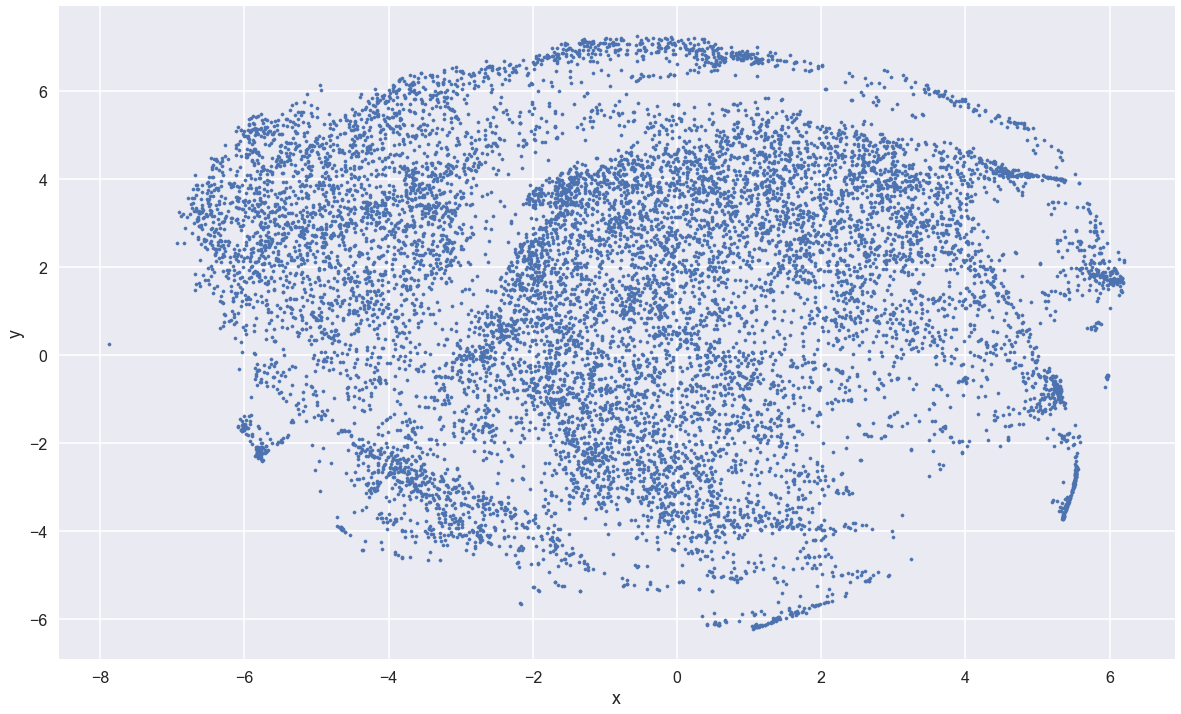

In [25]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

### Zoom to some places

In [26]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

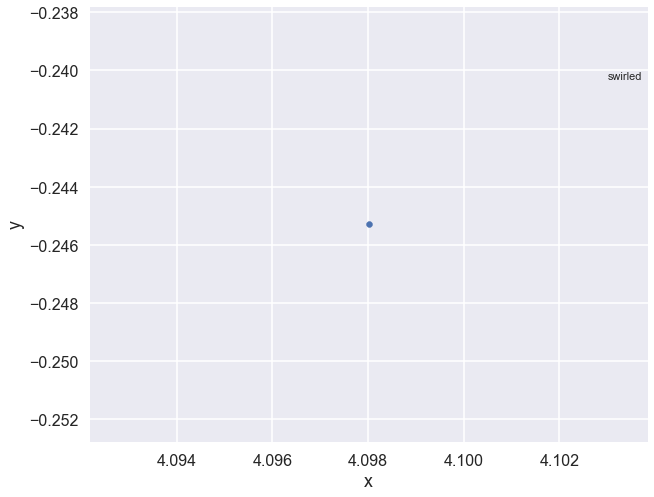

In [27]:
plot_region(x_bounds=(4.0, 4.2), y_bounds=(-0.5, -0.1))

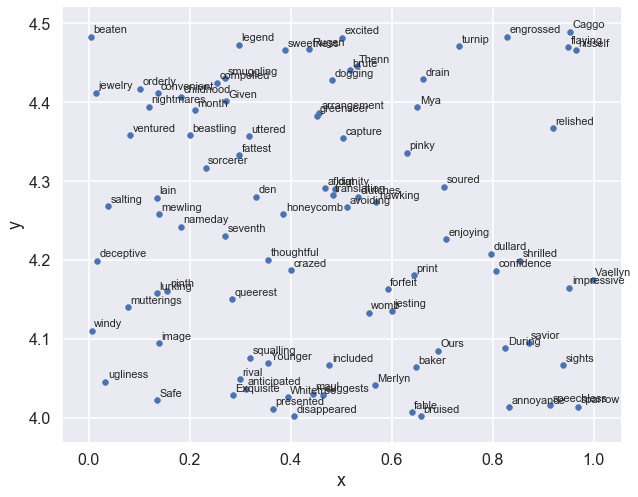

In [28]:
plot_region(x_bounds=(0, 1), y_bounds=(4, 4.5))

### Explore semantic similarities between book characters

#### Words closest to the given word

In [29]:
thrones2vec.most_similar("Stark")

[('Eddard', 0.8115077018737793),
 ('Brandon', 0.7628499269485474),
 ('Robb', 0.7619760036468506),
 ('Winterfell', 0.7493209838867188),
 ('ward', 0.7473243474960327),
 ('Lysa', 0.7435698509216309),
 ('Benjen', 0.7430411577224731),
 ('Tully', 0.7402748465538025),
 ('beheaded', 0.739292323589325),
 ('Bolton', 0.7365069389343262)]

In [30]:
thrones2vec.most_similar("Aerys")

[('Daeron', 0.9071556329727173),
 ('Sack', 0.891964852809906),
 ('Rhaegar', 0.889130711555481),
 ('Beggar', 0.8813490867614746),
 ('Mad', 0.8767156004905701),
 ('Targaryen', 0.8645896911621094),
 ('Robert', 0.8636147975921631),
 ('reign', 0.8615184426307678),
 ('fealty', 0.8608161211013794),
 ('rightful', 0.8573300838470459)]

In [31]:
thrones2vec.most_similar("direwolf")

[('pup', 0.7789115905761719),
 ('wight', 0.7698267102241516),
 ('wolf', 0.7669732570648193),
 ('sullen', 0.7523638010025024),
 ('gasp', 0.7491850256919861),
 ('guardsman', 0.7463486790657043),
 ('stern', 0.7391389608383179),
 ('stiffly', 0.7363890409469604),
 ('horror', 0.7265360951423645),
 ('widened', 0.7261286377906799)]

### Linear relationship between word pairs

In [32]:
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = thrones2vec.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [33]:
nearest_similarity_cosmul("Stark", "Winterfell", "Riverrun")
nearest_similarity_cosmul("Jaime", "sword", "wine")
nearest_similarity_cosmul("Arya", "Nymeria", "dragons")

Stark is related to Winterfell, as Edmure is related to Riverrun
Jaime is related to sword, as Tyrion is related to wine
Arya is related to Nymeria, as dragon is related to dragons


'dragon'